### Project 2 - Noise Removal
### ECE574/692 - Computer Vision, Spring 2025
### Matthew Jones 
### Dr. Qi
### 3/14/25

In [1]:
# Convert NP to TORCH for efficient training
# Try optimized bilat and NLM

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Subset, DataLoader
import random
import bm3d
import torch.nn.functional as F
import torch
#from pil import Image
import os
from torchvision import datasets, transforms


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [57]:
# Define Denoising Autoencoder (DAE)
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 28x28 -> 14x14
            nn.Conv2d(6, 12, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)   # 14x14 -> 7x7
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(12, 6, kernel_size=2, stride=2),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(6, 1, kernel_size=2, stride=2),   # 14x14 -> 28x28
            nn.Sigmoid()  # Normalize output between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [4]:
# This DAE was not used because it actually provided worse results than the original DAE model. 
## DAE with dropout and scheduler
# Define Denoising Autoencoder (DAE) with Batch Normalization, Dropout, and Rate Scheduler
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()

        # Encoder with Batch Normalization and Dropout
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(6),
            nn.ReLU(),
            nn.Dropout(0.2),            # ADDED: Dropout
            nn.MaxPool2d(2, 2),         # 28x28 -> 14x14

            nn.Conv2d(6, 12, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(12),
            nn.ReLU(),
            nn.Dropout(0.2),            # ADDED: Dropout
            nn.MaxPool2d(2, 2)          # 14x14 -> 7x7
        )

        # Decoder with optional dropout
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(12, 6, kernel_size=2, stride=2),  # 7x7 -> 14x14
            nn.ReLU(),
            nn.Dropout(0.2),            # ADDED: Dropout in decoder
            nn.ConvTranspose2d(6, 1, kernel_size=2, stride=2),   # 14x14 -> 28x28
            nn.Sigmoid()  # Normalize output between 0 and 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
# Function to add Gaussian noise
def add_noise(img, noise_factor=0.5):
    noisy_img = img + noise_factor * torch.randn_like(img)
    return torch.clamp(noisy_img, 0., 1.)

In [7]:
# Add Salt and Pepper noise
def add_salt_pepper_noise(img, noise_factor=0.05):
    """
    Adds salt and pepper noise to the input image.
    
    Parameters:
        img (torch.Tensor): Input image tensor with values in [0,1].
        noise_factor (float): Proportion of pixels to alter (default=0.05).
                              This represents the overall noise level.
    
    Returns:
        torch.Tensor: Noisy image with salt and pepper noise.
    """
    noisy_img = img.clone()
    # Generate a tensor of random values in [0,1] with the same shape as the image.
    rnd = torch.rand_like(noisy_img)
    
    # Set some pixels to 0 (pepper) and some to 1 (salt).
    # For pepper noise, pixels with random values less than half the noise factor become 0.
    noisy_img[rnd < noise_factor / 2] = 0.0
    
    # For salt noise, pixels with random values greater than 1 minus half the noise factor become 1.
    noisy_img[rnd > 1 - (noise_factor / 2)] = 1.0
    
    return noisy_img

In [6]:
# Visualize results
def show_images(original, noisy, denoised):
    fig, axes = plt.subplots(3, 10, figsize=(10, 3))
    for i in range(10):
        axes[0, i].imshow(original[i].squeeze(), cmap="gray")
        axes[1, i].imshow(noisy[i].squeeze(), cmap="gray")
        axes[2, i].imshow(denoised[i].squeeze(), cmap="gray")
        axes[0, i].axis("off")
        axes[1, i].axis("off")
        axes[2, i].axis("off")
    axes[0, 0].set_ylabel("Original")
    axes[1, 0].set_ylabel("Noisy")
    axes[2, 0].set_ylabel("Denoised")
    plt.show()

In [9]:
### BM3D GPU Optimized (with Torch)
def bm3d_denoise_torch(image, sigma=0.1, device=None):
    """
    Apply BM3D denoising on a 2D torch.Tensor image.
    
    Parameters:
        image (torch.Tensor): 2D image tensor with values in [0,1].
        sigma (float): Estimated noise standard deviation.
        device (torch.device or None): Device for computation (e.g., cuda or cpu).
        
    Returns:
        torch.Tensor: Denoised 2D image.
    """
    # Select device: GPU if available, otherwise CPU.
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Ensure the image is a float tensor on the desired device.
    image = image.to(device).float()
    
    # Clamp the image values to ensure they are within [0,1].
    image = torch.clamp(image, 0, 1)
    
    # Convert the torch tensor to a numpy array (bm3d works on numpy).
    image_np = image.cpu().numpy()
    
    # Apply BM3D denoising using the bm3d library.
    denoised_np = bm3d.bm3d(image_np, sigma_psd=sigma)
    
    # Clamp the output to ensure values remain within [0,1].
    denoised_np = np.clip(denoised_np, 0, 1)
    
    # Convert the result back to a torch tensor on the selected device.
    denoised = torch.from_numpy(denoised_np).to(device)
    return denoised

In [9]:
# -----------------------------
# Non-local Means Denoising Implementation - METHOD NOT CURRENT USED DUE TO LONG RUNTIME. I left it because it is easier to read through
# -----------------------------
def non_local_means_denoise(image_np, patch_size=3, search_window=7, h=0.1):
    """
    Apply non-local means denoising on a 2D numpy array image.
    
    Parameters:
        image_np (numpy.ndarray): 2D image array with values in [0,1].
        patch_size (int): Size of the patch (odd number).
        search_window (int): Size of the search window (odd number).
        h (float): Filtering parameter controlling decay of the exponential.
        
    Returns:
        denoised (numpy.ndarray): Denoised 2D image.
    """

    # Ensure patch_size and search_window are odd
    # This will be added to the image to allow the patch to go through the image and be 
    # centered on each individual pixel
    pad_patch = patch_size // 2
    
    # Used to allow a search window centered on each pixel
    pad_search = search_window // 2
    
    # Pad image to handle borders
    # reflects image values into the padded areas
    padded = np.pad(image_np, pad_patch + pad_search, mode='reflect')
    h2 = h * h
    H, W = image_np.shape
    denoised = np.zeros_like(image_np)
    
    # Loop over each pixel in the original image
    for i in range(H):
        for j in range(W):
            i_p = i + pad_patch + pad_search
            j_p = j + pad_patch + pad_search
            
            # Extract central patch
            patch = padded[i_p-pad_patch:i_p+pad_patch+1, j_p-pad_patch:j_p+pad_patch+1]
            weight_sum = 0.0
            pixel_val = 0.0
            
            # Loop over the search window
            # The nested loops over k and l cover all neighboring pixels within 
            # the search_window centered at the current pixel.
            for k in range(i_p - pad_search, i_p + pad_search + 1):
                for l in range(j_p - pad_search, j_p + pad_search + 1):
                    
                    # patch to compare to the current pixel patch
                    neighbor_patch = padded[k-pad_patch:k+pad_patch+1, l-pad_patch:l+pad_patch+1]
                    
                    # Compute squared Euclidean distance between different patches
                    d2 = np.sum((patch - neighbor_patch)**2)
                    
                    # Compute weight as exponential of negative distance
                    # This means similar patches (with low d2) contribute more heavily to the denoised value, 
                    # while dissimilar patches contribute very little.
                    weight = np.exp(-d2 / h2)
                    weight_sum += weight
                    pixel_val += weight * padded[k, l]
            
            # Normalize the denoised pixel value by the sum of weights
            # If weight_sum is zero, we keep the original pixel value
            # pixel_val is the sum of all the contributions from neighboring pixels
            # weight_sum is the sum of all the weights
            denoised[i, j] = pixel_val / weight_sum if weight_sum != 0 else image_np[i, j]
    return denoised

In [10]:

### NLM Denoising GPU optimzed (by using torch) - METHOD CURRENTLY USED
"""
Below is an optimized PyTorch implementation that leverages vectorized patch extraction with 
unfolding and runs on the GPU if available. In this version the heavy per-pixel loops are 
replaced by a double loop over the (small) search window, while the expensive patch extraction 
and distance computations are fully vectorized:
""";
def non_local_means_denoise_torch(image, patch_size=3, search_window=7, h=0.1, device=None):
    """
    Apply non-local means denoising on a 2D image using PyTorch.
    
    Parameters:
        image (torch.Tensor): 2D tensor of shape (H, W) with values in [0,1].
        patch_size (int): Size of the patch (odd number).
        search_window (int): Size of the search window (odd number).
        h (float): Filtering parameter controlling decay of the exponential.
        device (torch.device or None): Device to run the computation (e.g. cuda or cpu).
        
    Returns:
        torch.Tensor: Denoised 2D image of shape (H, W).
    """
    # Use GPU if available and device not specified
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Ensure the image tensor is on the right device and has shape (1,1,H,W)
    image = image.to(device).float()
    if image.dim() == 2:
        image = image.unsqueeze(0).unsqueeze(0)
    
    H, W = image.shape[2], image.shape[3]
    pad_patch = patch_size // 2
    pad_search = search_window // 2
    # Total padding to allow both patch extraction and search window movement
    pad_total = pad_patch + pad_search
    
    # Pad the image with reflect mode so borders are handled correctly
    padded = F.pad(image, (pad_total, pad_total, pad_total, pad_total), mode='reflect')
    
    # Extract patches using unfold.
    # The unfolded tensor has shape: (1, patch_size*patch_size, L) where L is the number of sliding positions.
    patches = F.unfold(padded, kernel_size=patch_size, stride=1)
    # The spatial dimensions of the patches tensor are:
    H_eff = H + 2 * pad_search  # = H+2*pad_search
    W_eff = W + 2 * pad_search  # = W+2*pad_search
    patches = patches.view(1, patch_size * patch_size, H_eff, W_eff)
    
    # Extract the central patches corresponding to the original image positions.
    # These are located at indices starting at pad_search and spanning H and W.
    central_patches = patches[:, :, pad_search:pad_search+H, pad_search:pad_search+W]
    
    # Prepare accumulators for the weighted sum of pixel intensities and the weights.
    weight_sum = torch.zeros_like(image, device=device)
    pixel_sum  = torch.zeros_like(image, device=device)
    h2 = h * h

    # Loop over each offset within the search window.
    # Note: The search window is usually small so this loop (of size search_window^2)
    # does not impact performance significantly.
    for dy in range(-pad_search, pad_search + 1):
        for dx in range(-pad_search, pad_search + 1):
            # For neighbor patches, shift the spatial indices in the patches tensor.
            neighbor_patches = patches[:, :,
                                       pad_search + dy: pad_search + dy + H,
                                       pad_search + dx: pad_search + dx + W]
            # Compute squared Euclidean distance between the central and neighbor patches.
            diff = (central_patches - neighbor_patches) ** 2
            d2 = torch.sum(diff, dim=1, keepdim=True)  # shape: (1, 1, H, W)
            # Compute the weight for the current offset.
            w = torch.exp(-d2 / h2)
            
            # Get the neighbor pixel intensities from the padded image.
            # The neighbor pixel (for the central pixel at padded coordinate (i+pad_total, j+pad_total))
            # is at (i+pad_total+dy, j+pad_total+dx).
            neighbor_pixel = padded[:, :,
                                    pad_total + dy: pad_total + dy + H,
                                    pad_total + dx: pad_total + dx + W]
            
            # Accumulate the weighted pixel values and the weights.
            weight_sum += w
            pixel_sum  += w * neighbor_pixel

    # Normalize to obtain the final denoised image.
    denoised = pixel_sum / weight_sum
    return denoised.squeeze(0).squeeze(0)  # return shape (H, W)

In [11]:
# -----------------------------
# Bilateral Filtering Denoising Implementation - METHOD NOT CURRENTLY USED DUE TO LONG RUNTIME, but I left because it is easier to read through
# -----------------------------
def bilateral_filter(image_np, kernel_size = 3, spatial_sigma=1.0, intensity_sigma=0.1):
    """
    Apply bilateral filtering on a 2D numpy array image.
    
    Parameters:
        image_np (numpy.ndarray): 2D image array with values in [0,1].
        kernel_size (int): Size of the bilateral filter kernel (odd number).
        spatial_sigma (float): Standard deviation for the spatial Gaussian. Controls weight based on Euclidean distance.
            A smaller value means that only pixels close to the center pixel will contribute to the denoised value.
        intensity_sigma (float): Standard deviation for the range Gaussian. Controls weight based on intensity difference. A
            smaller value means that only pixels with very similar intensities will contribute to the denoised value.
        
    Returns:
        filtered (numpy.ndarray): Denoised 2D image.
    """
    pad = kernel_size // 2
    padded = np.pad(image_np, pad, mode='reflect')
    H, W = image_np.shape
    
    # Initialize filtered image
    filtered = np.zeros_like(image_np)
    
    # Precompute spatial Gaussian weights
    x, y = np.meshgrid(np.arange(kernel_size), np.arange(kernel_size))
    x = x - pad
    y = y - pad
    
    # Compute spatial Gaussian weights
    spatial_weight = np.exp(-(x**2 + y**2) / (2 * spatial_sigma**2))
    
    for i in range(H):
        for j in range(W):
            i_p = i + pad
            j_p = j + pad
            center_val = padded[i_p, j_p]
            
            # Extract local window from padded image
            window = padded[i_p - pad:i_p + pad + 1, j_p - pad:j_p + pad + 1]
            
            # Compute range Gaussian weights based on intensity differences
            intensity_weight = np.exp(-((window - center_val)**2) / (2 * intensity_sigma**2))
            
            # Combined bilateral weight
            weights = spatial_weight * intensity_weight
            
            
            weight_sum = np.sum(weights)
            
            # Normalize and compute filtered value
            filtered[i, j] = np.sum(window * weights) / weight_sum
    return filtered

In [11]:
### Bilateral Filtering GPU optimized (torch) - METHOD CURRENTLY USED
def bilateral_filter_torch(image, kernel_size=3, spatial_sigma=1.0, intensity_sigma=0.1, device=None):
    """
    Apply bilateral filtering on a 2D image using PyTorch with GPU acceleration.
    
    Parameters:
        image (torch.Tensor): 2D tensor with shape (H, W) and values in [0,1].
        kernel_size (int): Size of the bilateral filter kernel (must be odd).
        spatial_sigma (float): Standard deviation for the spatial Gaussian.
        intensity_sigma (float): Standard deviation for the range (intensity) Gaussian.
        device (torch.device or None): Device to run the computation (e.g., cuda or cpu).
        
    Returns:
        torch.Tensor: Denoised 2D image with shape (H, W).
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Move image to device and ensure it has shape (1, 1, H, W)
    image = image.to(device).float()
    if image.dim() == 2:
        image = image.unsqueeze(0).unsqueeze(0)
    
    H, W = image.shape[2], image.shape[3]
    pad = kernel_size // 2
    
    # Pad the image using reflection padding to handle borders.
    padded = F.pad(image, (pad, pad, pad, pad), mode='reflect')
    
    # Extract all local patches in one shot using unfold.
    # patches shape: (1, kernel_size*kernel_size, H*W)
    patches = F.unfold(padded, kernel_size=kernel_size, stride=1)
    
    # Precompute the spatial Gaussian weights.
    xs = torch.arange(kernel_size, device=device) - pad
    ys = torch.arange(kernel_size, device=device) - pad
    xv, yv = torch.meshgrid(xs, ys, indexing='ij')
    spatial_weight = torch.exp(-(xv**2 + yv**2) / (2 * spatial_sigma**2))
    # Reshape spatial_weight to broadcast with patches: shape (1, kernel_size*kernel_size, 1)
    spatial_weight = spatial_weight.view(1, -1, 1)
    
    # Identify the center pixel for each patch (assumes row-major order).
    center_idx = (kernel_size * kernel_size) // 2
    center_pixel = patches[:, center_idx:center_idx+1, :]  # shape: (1, 1, H*W)
    
    # Compute the intensity difference between each patch element and its center pixel.
    intensity_diff = patches - center_pixel  # shape: (1, kernel_size*kernel_size, H*W)
    intensity_weight = torch.exp(- (intensity_diff ** 2) / (2 * intensity_sigma**2))
    
    # Combined bilateral weights: multiply spatial and intensity weights.
    weights = spatial_weight * intensity_weight  # shape: (1, kernel_size*kernel_size, H*W)
    
    # Compute the weighted sum of patch pixels.
    weighted_sum = torch.sum(weights * patches, dim=1, keepdim=True)
    weights_sum = torch.sum(weights, dim=1, keepdim=True)
    filtered = weighted_sum / weights_sum  # shape: (1, 1, H*W)
    
    # Reshape to (H, W) and return.
    return filtered.view(H, W)

In [12]:
def calculate_psnr(original, denoised):
    """
    Calculate the Peak Signal-to-Noise Ratio (PSNR) between the original and denoised images.
    
    Parameters:
        original (numpy.ndarray): Original 2D image array with values in [0,1].
        denoised (numpy.ndarray): Denoised 2D image array with values in [0,1].
        
    Returns:
        psnr (float): PSNR value in decibels (dB). A higher value indicates better image quality.
    """
    # Compute the Mean Squared Error (MSE) between the images.
    mse = np.mean((original - denoised) ** 2)
    
    # If MSE is zero, return infinity (perfect match)
    if mse == 0:
        return float('inf')
    
    # Maximum pixel value for images in [0,1] is 1.
    psnr = 10 * np.log10(1.0 / mse)
    return psnr

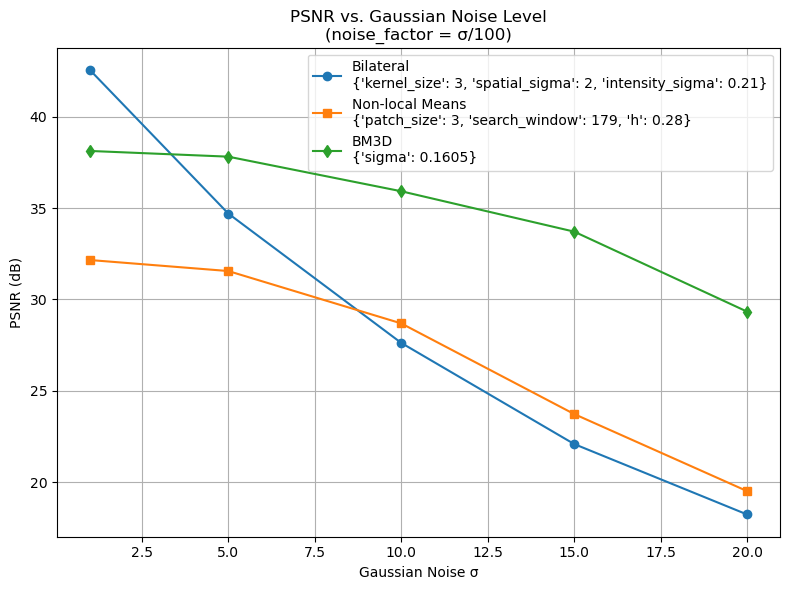

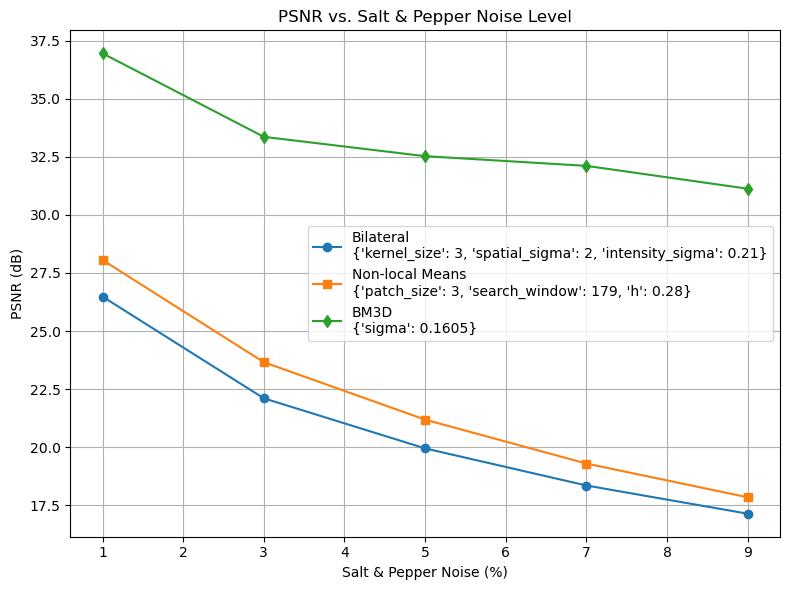

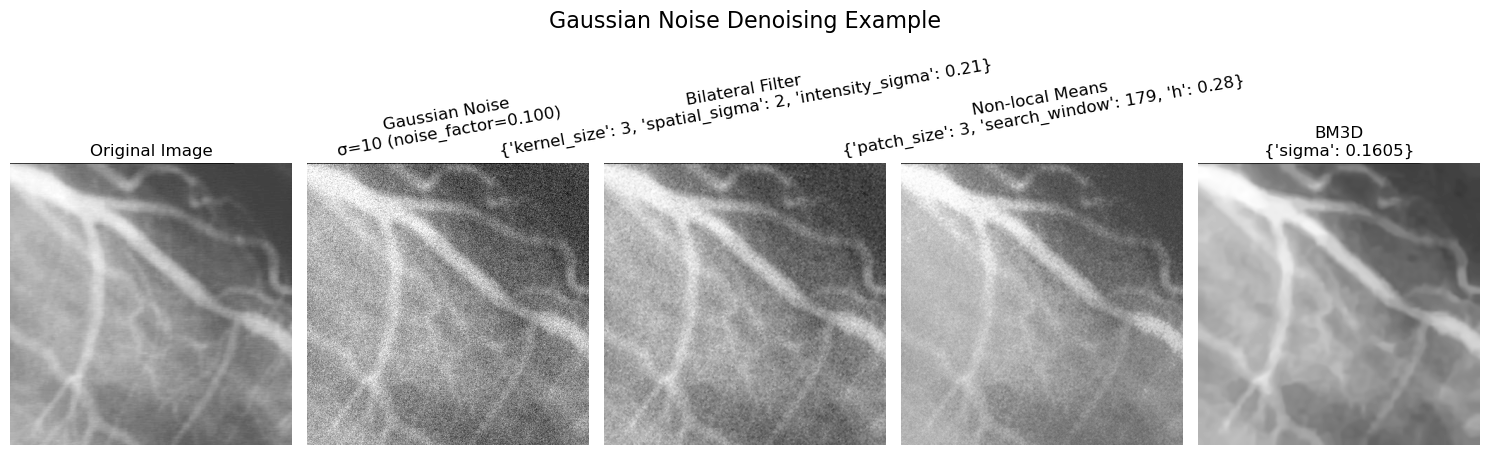

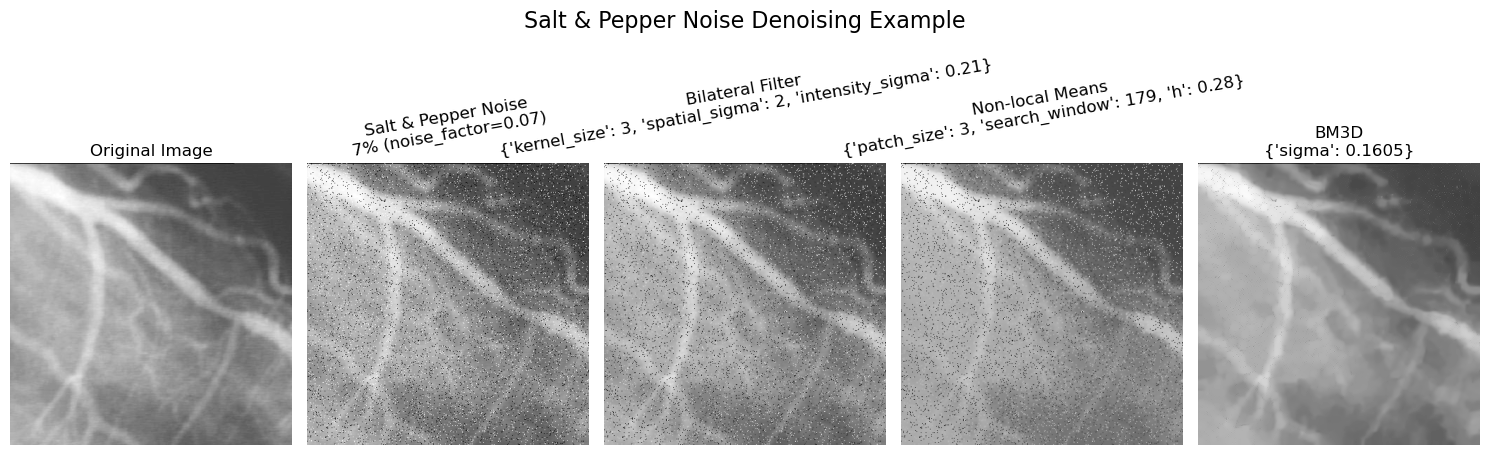

In [109]:
# Figures showing noisying and denoising on the angio.pgm image and noise vs PSNR for different models
# -----------------------------
# Parameters (easily changeable)
# -----------------------------
# Gaussian noise parameters (σ values in the image domain: for add_noise, we convert to a noise_factor)
gaussian_sigmas = [1, 5, 10, 15, 20]

# Salt & Pepper noise percentages (in %; note: noise_factor in add_salt_pepper_noise is the proportion of pixels altered)
snp_percentages = [1, 3, 5, 7, 9]  

# Denoising parameters: Spatial was 1.4
bilateral_params = {"kernel_size": 3, "spatial_sigma": 2, "intensity_sigma": 0.21}
non_local_params = {"patch_size": 3, "search_window": 179, "h": 0.28}
bm3d_params = {"sigma": 0.1605}  # Note: bm3d expects sigma in the same scale as the image (i.e., [0,1])

# Conversion: since images are in [0,1], we assume σ_image = sigma/100.
def sigma_to_noise_factor(sigma):
    return sigma / 100

# -----------------------------
# NEW: Load the "angio.pgm" file for testing
# -----------------------------
original_img = plt.imread("angio.pgm")  # load the pgm image (assumed to be grayscale with values in [0,1])
if original_img.ndim == 3:
    original_img = original_img[..., 0]  # if the image has multiple channels, take the first one

# CHANGE: Check if the image is in the [0,1] range. If not, normalize it.
if original_img.max() > 1:
    original_img = original_img / 255.0  # Normalize assuming original image is in 0-255 range

sample_img = torch.from_numpy(original_img).unsqueeze(0).float()  # convert to torch.Tensor with shape (1,H,W)

# -----------------------------
# Figure 1: PSNR vs. Gaussian noise level for 3 methods
# -----------------------------
psnr_bilateral_gauss = []
psnr_nonlocal_gauss = []
psnr_bm3d_gauss = []

for sigma in gaussian_sigmas:
    # Convert sigma to noise_factor for add_noise
    noise_factor = sigma_to_noise_factor(sigma)
    # Add Gaussian noise using torch (output is a tensor)
    noisy_tensor = add_noise(sample_img, noise_factor=noise_factor)
    # Work with the 2D torch tensor (remove extra dims)
    noisy_img_torch = noisy_tensor.squeeze()  # shape: (H, W)
    
    # Denoise using bilateral filter (torch implementation)
    denoised_bilateral = bilateral_filter_torch(noisy_img_torch, **bilateral_params, device=device)
    denoised_bilateral_np = denoised_bilateral.cpu().numpy()
    psnr_bilateral_gauss.append(calculate_psnr(original_img, denoised_bilateral_np))
    
    # Denoise using non-local means (torch implementation)
    denoised_nonlocal = non_local_means_denoise_torch(noisy_img_torch, **non_local_params, device=device)
    denoised_nonlocal_np = denoised_nonlocal.cpu().numpy()
    psnr_nonlocal_gauss.append(calculate_psnr(original_img, denoised_nonlocal_np))
    
    # Denoise using BM3D (torch implementation)
    denoised_bm3d = bm3d_denoise_torch(noisy_img_torch, sigma=bm3d_params["sigma"], device=device)
    denoised_bm3d_np = denoised_bm3d.cpu().numpy()
    psnr_bm3d_gauss.append(calculate_psnr(original_img, denoised_bm3d_np))

plt.figure(figsize=(8,6))
plt.plot(gaussian_sigmas, psnr_bilateral_gauss, 'o-', label=f'Bilateral\n{bilateral_params}')
plt.plot(gaussian_sigmas, psnr_nonlocal_gauss, 's-', label=f'Non-local Means\n{non_local_params}')
plt.plot(gaussian_sigmas, psnr_bm3d_gauss, 'd-', label=f'BM3D\n{bm3d_params}')
plt.xlabel("Gaussian Noise σ")
plt.ylabel("PSNR (dB)")
plt.title("PSNR vs. Gaussian Noise Level\n(noise_factor = σ/100)")
plt.legend()
plt.grid(True)
plt.tight_layout()

# -----------------------------
# Figure 2: PSNR vs. Salt & Pepper noise level for 3 methods
# -----------------------------
psnr_bilateral_snp = []
psnr_nonlocal_snp = []
psnr_bm3d_snp = []

for perc in snp_percentages:
    # Convert percentage to noise_factor (proportion)
    noise_factor = perc / 100.0
    # Add salt and pepper noise using torch
    noisy_tensor = add_salt_pepper_noise(sample_img, noise_factor=noise_factor)
    noisy_img_torch = noisy_tensor.squeeze()  # shape: (H, W)
    
    # Denoise using bilateral filter (torch implementation)
    denoised_bilateral = bilateral_filter_torch(noisy_img_torch, **bilateral_params, device=device)
    denoised_bilateral_np = denoised_bilateral.cpu().numpy()
    psnr_bilateral_snp.append(calculate_psnr(original_img, denoised_bilateral_np))
    
    # Denoise using non-local means (torch implementation)
    denoised_nonlocal = non_local_means_denoise_torch(noisy_img_torch, **non_local_params, device=device)
    denoised_nonlocal_np = denoised_nonlocal.cpu().numpy()
    psnr_nonlocal_snp.append(calculate_psnr(original_img, denoised_nonlocal_np))

    # Denoise using BM3D (torch implementation)
    denoised_bm3d = bm3d_denoise_torch(noisy_img_torch, sigma=bm3d_params["sigma"], device=device)
    denoised_bm3d_np = denoised_bm3d.cpu().numpy()
    psnr_bm3d_snp.append(calculate_psnr(original_img, denoised_bm3d_np))


plt.figure(figsize=(8,6))
plt.plot(snp_percentages, psnr_bilateral_snp, 'o-', label=f'Bilateral\n{bilateral_params}')
plt.plot(snp_percentages, psnr_nonlocal_snp, 's-', label=f'Non-local Means\n{non_local_params}')
plt.plot(snp_percentages, psnr_bm3d_snp, 'd-', label=f'BM3D\n{bm3d_params}')
plt.xlabel("Salt & Pepper Noise (%)")
plt.ylabel("PSNR (dB)")
plt.title("PSNR vs. Salt & Pepper Noise Level")
plt.legend()
plt.grid(True)
plt.tight_layout()

subplot_rotation = 10

# -----------------------------
# Figure 3: Example with Gaussian noise (5 subplots)
# -----------------------------
# Choose a specific Gaussian noise level to visualize (e.g., σ=30)
example_sigma = 10
example_noise_factor = sigma_to_noise_factor(example_sigma)
example_noisy_tensor = add_noise(sample_img, noise_factor=example_noise_factor)
example_noisy_img_torch = example_noisy_tensor.squeeze()  # torch tensor

# Denoise with each method using torch implementations
example_denoised_bilateral = bilateral_filter_torch(example_noisy_img_torch, **bilateral_params, device=device)
example_denoised_nonlocal = non_local_means_denoise_torch(example_noisy_img_torch, **non_local_params, device=device)
example_denoised_bm3d = bm3d_denoise_torch(example_noisy_img_torch, sigma=bm3d_params["sigma"], device=device)

plt.figure(figsize=(15,5))
plt.subplot(1,5,1)
plt.imshow(original_img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,5,2)
plt.imshow(example_noisy_tensor.squeeze().cpu().numpy(), cmap='gray')
t = plt.title(f"Gaussian Noise\nσ={example_sigma} (noise_factor={example_noise_factor:.3f})")
t.set_rotation(subplot_rotation)
plt.axis('off')

plt.subplot(1,5,3)
plt.imshow(example_denoised_bilateral.cpu().numpy(), cmap='gray')
t = plt.title(f"Bilateral Filter\n{bilateral_params}")
t.set_rotation(subplot_rotation)
plt.axis('off')

plt.subplot(1,5,4)
plt.imshow(example_denoised_nonlocal.cpu().numpy(), cmap='gray')
t = plt.title(f"Non-local Means\n{non_local_params}")
t.set_rotation(subplot_rotation)
plt.axis('off')

plt.subplot(1,5,5)
plt.imshow(example_denoised_bm3d, cmap='gray')
plt.title(f"BM3D\n{bm3d_params}")
plt.axis('off')
plt.suptitle("Gaussian Noise Denoising Example", fontsize=16, y=.98)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(top=0.75)

# -----------------------------
# Figure 4: Example with Salt & Pepper noise (5 subplots)
# -----------------------------
# Choose a specific salt & pepper noise level to visualize (e.g., 12%)
example_snp_percentage = 7
example_snp_noise_factor = example_snp_percentage / 100.0
example_snp_noisy_tensor = add_salt_pepper_noise(sample_img, noise_factor=example_snp_noise_factor)
example_snp_noisy_img_torch = example_snp_noisy_tensor.squeeze()

# Denoise with each method using torch implementations
example_snp_denoised_bilateral = bilateral_filter_torch(example_snp_noisy_img_torch, **bilateral_params, device=device)
example_snp_denoised_nonlocal = non_local_means_denoise_torch(example_snp_noisy_img_torch, **non_local_params, device=device)
example_snp_denoised_bm3d = bm3d_denoise_torch(example_snp_noisy_img_torch, sigma=bm3d_params["sigma"], device=device)

plt.figure(figsize=(15,5))
plt.subplot(1,5,1)
plt.imshow(original_img, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1,5,2)
plt.imshow(example_snp_noisy_tensor.squeeze().cpu().numpy(), cmap='gray')
t = plt.title(f"Salt & Pepper Noise\n{example_snp_percentage}% (noise_factor={example_snp_noise_factor:.2f})")
t.set_rotation(subplot_rotation)
plt.axis('off')

plt.subplot(1,5,3)
plt.imshow(example_snp_denoised_bilateral.cpu().numpy(), cmap='gray')
t = plt.title(f"Bilateral Filter\n{bilateral_params}")
t.set_rotation(subplot_rotation)
plt.axis('off')

plt.subplot(1,5,4)
plt.imshow(example_snp_denoised_nonlocal.cpu().numpy(), cmap='gray')
t = plt.title(f"Non-local Means\n{non_local_params}")
t.set_rotation(subplot_rotation)
plt.axis('off')

plt.subplot(1,5,5)
plt.imshow(example_snp_denoised_bm3d, cmap='gray')
plt.title(f"BM3D\n{bm3d_params}")
plt.axis('off')
plt.suptitle("Salt & Pepper Noise Denoising Example", fontsize=16, y=.98)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.subplots_adjust(top=0.75)

plt.show()


In [13]:
# -----------------------------
# Updated visualization function with BM3D and new order:
# Order: Original, Noisy, Bilateral, NLM, BM3D.
# Row labels include noise and denoising parameters.
# -----------------------------
def show_images_with_all(original, noisy, bilateral, nlm, bm3d, row_labels):
    fig, axes = plt.subplots(5, 10, figsize=(10, 5))
    for i in range(10):
        axes[0, i].imshow(original[i].squeeze(), cmap="gray")
        axes[1, i].imshow(noisy[i].squeeze(), cmap="gray")
        axes[2, i].imshow(bilateral[i].squeeze(), cmap="gray")
        axes[3, i].imshow(nlm[i].squeeze(), cmap="gray")
        axes[4, i].imshow(bm3d[i].squeeze(), cmap="gray")
        for r in range(5):
            axes[r, i].axis("off")
    plt.tight_layout()
    # Added: For each row, get the left-most axis position and add a text label there.
    for r in range(5):
        pos = axes[r, 0].get_position()  # returns Bbox in figure coordinates
        y_center = (pos.y0 + pos.y1) / 2
        # Place the text just to the left of the first column
        fig.text(pos.x0 - 0.03, y_center, row_labels[r],
                 va='center', ha='right', fontsize=12, rotation=0)
    plt.show()




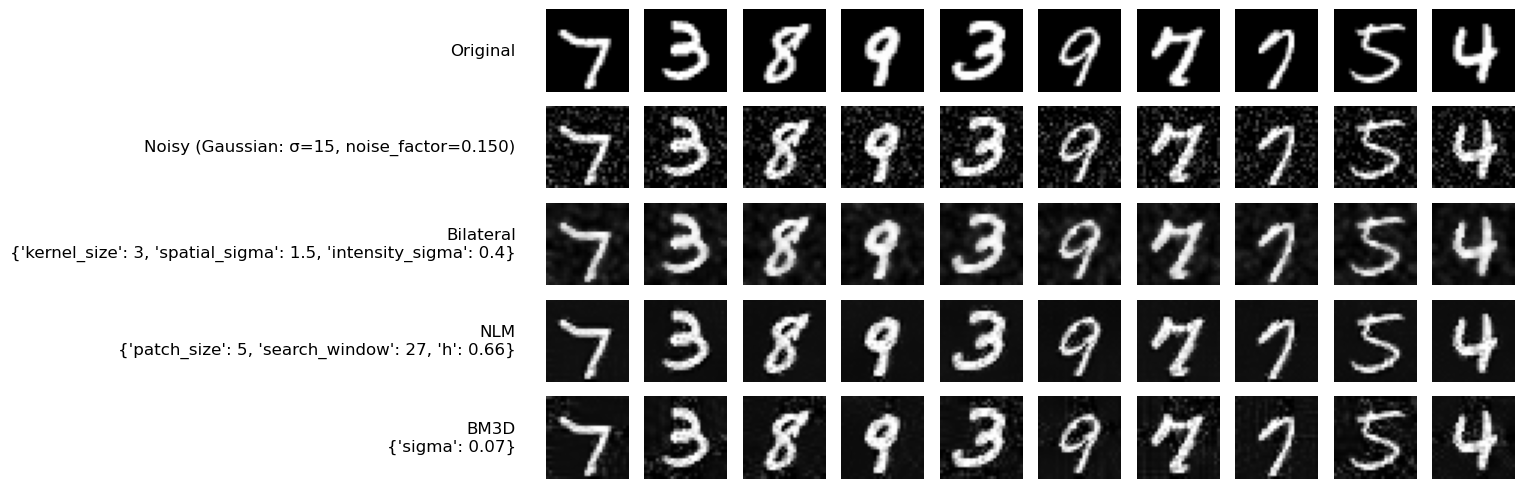

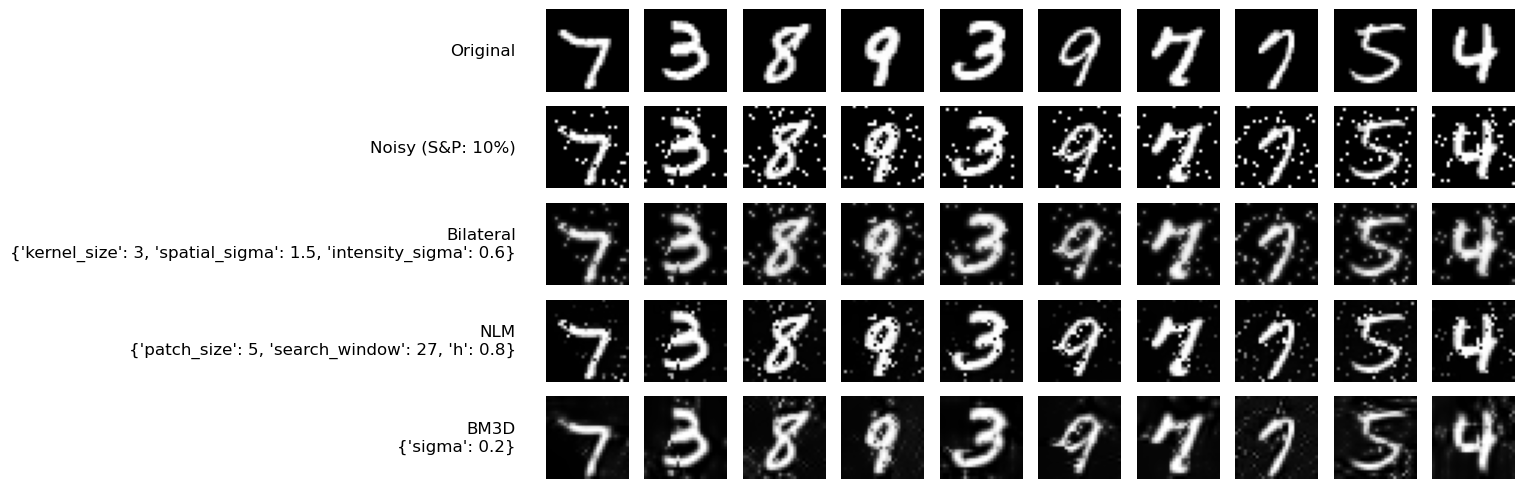

In [107]:
# =============================
# Parameters (Noise & Denoising)
# =============================

# For this example, we assume a conversion factor (change as needed)
def sigma_to_noise_factor(sigma):
    return sigma / 100  

"""
# Denoising parameters:
bilateral_params = {"kernel_size": 3, "spatial_sigma": 1.5, "intensity_sigma": 0.4}
non_local_params = {"patch_size": 3, "search_window": 27, "h": 0.25}
bm3d_params = {"sigma": 0.15}  # BM3D expects sigma in [0,1] scale
"""

# Denoising parameters:
bilateral_params = {"kernel_size": 3, "spatial_sigma": 1.5, "intensity_sigma": 0.4}
non_local_params = {"patch_size": 5, "search_window": 27, "h": 0.66}
bm3d_params = {"sigma": 0.07}  # BM3D expects sigma in [0,1] scale

example_sigma = 15  # choose one sigma for visualization
example_snp_percentage = 10


# -----------------------------
# Check if GPU is available
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# NEW: Load 10 random, repeatable MNIST dataset images for testing instead of using angio.pgm
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
indices = np.random.choice(len(mnist_dataset), 10, replace=False)
test_imgs = torch.stack([mnist_dataset[i][0] for i in indices])
# End NEW

# -----------------------------
# Gaussian Noise Example
# -----------------------------
noise_factor = sigma_to_noise_factor(example_sigma)
test_noisy = add_noise(test_imgs, noise_factor=noise_factor)

# Compute NLM denoising for first 10 images (using optimized Torch function)
non_local_denoised = []
test_noisy_np = test_noisy.cpu().numpy()  # shape: (10, 1, H, W)
for i in range(10):
    image_np = test_noisy_np[i, 0, :, :]
    denoised_np = non_local_means_denoise_torch(torch.from_numpy(image_np), 
                                                 patch_size=non_local_params["patch_size"],
                                                 search_window=non_local_params["search_window"],
                                                 h=non_local_params["h"],
                                                 device=device).cpu().numpy()
    non_local_denoised.append(denoised_np)
non_local_denoised = np.array(non_local_denoised)
non_local_denoised_tensor = torch.from_numpy(non_local_denoised).unsqueeze(1)

# Compute Bilateral filtering for first 10 images (using optimized Torch function)
bilateral_denoised = []
for i in range(10):
    image_np = test_noisy_np[i, 0, :, :]
    filtered_np = bilateral_filter_torch(torch.from_numpy(image_np),
                                         kernel_size=bilateral_params["kernel_size"],
                                         spatial_sigma=bilateral_params["spatial_sigma"],
                                         intensity_sigma=bilateral_params["intensity_sigma"],
                                         device=device).cpu().numpy()
    bilateral_denoised.append(filtered_np)
bilateral_denoised = np.array(bilateral_denoised)
bilateral_denoised_tensor = torch.from_numpy(bilateral_denoised).unsqueeze(1)

# Compute BM3D denoising for first 10 images (using torch implementation)
bm3d_denoised = []
for i in range(10):
    image_np = test_noisy_np[i, 0, :, :]
    # Convert to torch tensor, call the torch BM3D function, then convert result to numpy
    image_torch = torch.from_numpy(image_np)
    denoised_torch = bm3d_denoise_torch(image_torch, sigma=bm3d_params["sigma"], device=device)
    denoised_np = denoised_torch.cpu().numpy()
    bm3d_denoised.append(denoised_np)
bm3d_denoised = np.array(bm3d_denoised)
bm3d_denoised_tensor = torch.from_numpy(bm3d_denoised).unsqueeze(1)

# Set row labels (parameters are shown in the labels)
row_labels_gauss = [
    "Original",
    f"Noisy (Gaussian: σ={example_sigma}, noise_factor={noise_factor:.3f})",
    f"Bilateral\n{bilateral_params}",
    f"NLM\n{non_local_params}",
    f"BM3D\n{bm3d_params}"
]

# Display the Gaussian noise results
show_images_with_all(test_imgs.cpu(), test_noisy.cpu(), bilateral_denoised_tensor.cpu(),
                     non_local_denoised_tensor.cpu(), bm3d_denoised_tensor.cpu(), row_labels_gauss)


# Denoising parameters:
bilateral_params = {"kernel_size": 3, "spatial_sigma": 1.5, "intensity_sigma": 0.6}
non_local_params = {"patch_size": 5, "search_window": 27, "h": 0.8}
bm3d_params = {"sigma": 0.2}  # BM3D expects sigma in [0,1] scale

# -----------------------------
# Salt & Pepper Noise Example
# -----------------------------
snp_noise_factor = example_snp_percentage / 100.0
test_noisy_snp = add_salt_pepper_noise(test_imgs, noise_factor=snp_noise_factor)

test_noisy_snp_np = test_noisy_snp.cpu().numpy()

# Compute NLM denoising for salt & pepper noisy images
non_local_denoised_snp = []
for i in range(10):
    image_np = test_noisy_snp_np[i, 0, :, :]
    denoised_np = non_local_means_denoise_torch(torch.from_numpy(image_np),
                                                 patch_size=non_local_params["patch_size"],
                                                 search_window=non_local_params["search_window"],
                                                 h=non_local_params["h"],
                                                 device=device).cpu().numpy()
    non_local_denoised_snp.append(denoised_np)
non_local_denoised_snp = np.array(non_local_denoised_snp)
non_local_denoised_snp_tensor = torch.from_numpy(non_local_denoised_snp).unsqueeze(1)

# Compute Bilateral filtering for salt & pepper noisy images
bilateral_denoised_snp = []
for i in range(10):
    image_np = test_noisy_snp_np[i, 0, :, :]
    filtered_np = bilateral_filter_torch(torch.from_numpy(image_np),
                                         kernel_size=bilateral_params["kernel_size"],
                                         spatial_sigma=bilateral_params["spatial_sigma"],
                                         intensity_sigma=bilateral_params["intensity_sigma"],
                                         device=device).cpu().numpy()
    bilateral_denoised_snp.append(filtered_np)
bilateral_denoised_snp = np.array(bilateral_denoised_snp)
bilateral_denoised_snp_tensor = torch.from_numpy(bilateral_denoised_snp).unsqueeze(1)

# Compute BM3D denoising for salt & pepper noisy images (using torch implementation)
bm3d_denoised_snp = []
for i in range(10):
    image_np = test_noisy_snp_np[i, 0, :, :]
    image_torch = torch.from_numpy(image_np)
    denoised_torch = bm3d_denoise_torch(image_torch, sigma=bm3d_params["sigma"], device=device)
    denoised_np = denoised_torch.cpu().numpy()
    bm3d_denoised_snp.append(denoised_np)
bm3d_denoised_snp = np.array(bm3d_denoised_snp)
bm3d_denoised_snp_tensor = torch.from_numpy(bm3d_denoised_snp).unsqueeze(1)

row_labels_snp = [
    "Original",
    f"Noisy (S&P: {example_snp_percentage}%)",
    f"Bilateral\n{bilateral_params}",
    f"NLM\n{non_local_params}",
    f"BM3D\n{bm3d_params}"
]

# Display the Salt & Pepper noise results
show_images_with_all(test_imgs.cpu(), test_noisy_snp.cpu(), bilateral_denoised_snp_tensor.cpu(),
                     non_local_denoised_snp_tensor.cpu(), bm3d_denoised_snp_tensor.cpu(), row_labels_snp)



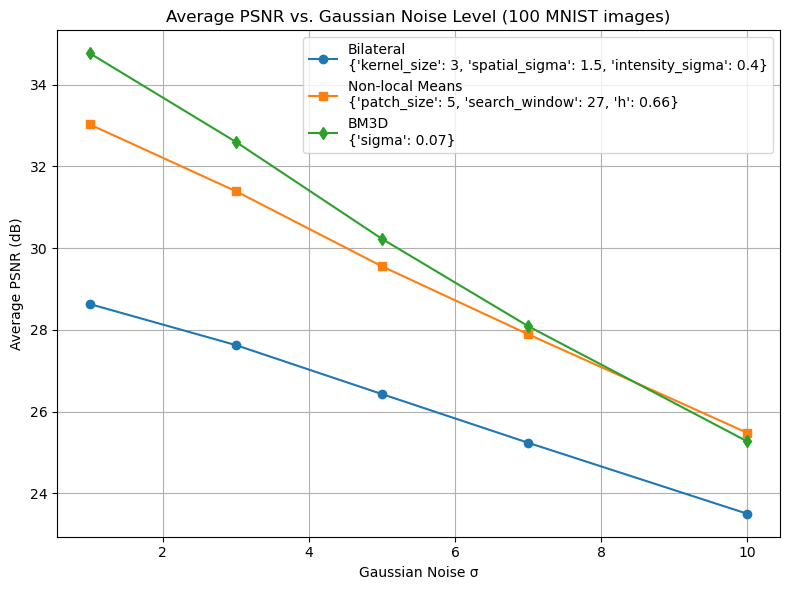

In [15]:
#### PSNT Vs. Gaussian Sigma Graph

# -----------------------------
# Parameters (Noise & Denoising)
# -----------------------------
def sigma_to_noise_factor(sigma):
    return sigma / 100  # Divide by 100 instead of 255

"""
# Denoising parameters:
bilateral_params = {"kernel_size": 3, "spatial_sigma": 1.5, "intensity_sigma": 0.4}
non_local_params = {"patch_size": 3, "search_window": 27, "h": 0.25}
bm3d_params = {"sigma": 0.15}  # BM3D expects sigma in [0,1] scale
"""

# NEW: Load 10 random, repeatable MNIST dataset images for testing instead of using angio.pgm
from torchvision import datasets, transforms
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
indices = np.random.choice(len(mnist_dataset), 10, replace=False)
test_imgs = torch.stack([mnist_dataset[i][0] for i in indices])


# Denoising parameters:
bilateral_params = {"kernel_size": 3, "spatial_sigma": 1.5, "intensity_sigma": 0.4}
non_local_params = {"patch_size": 5, "search_window": 27, "h": 0.66}
bm3d_params = {"sigma": 0.07}  # BM3D expects sigma in [0,1] scale

# Gaussian noise sigma values in the image domain
gaussian_sigmas = [1, 3, 5, 7, 10] #,15, 20]

# -----------------------------
# Check if GPU is available
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Load 100 random but repeatable MNIST images
# -----------------------------
seed = 42
num_images = 100
torch.manual_seed(seed)
np.random.seed(seed)
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
indices = np.random.choice(len(mnist_dataset), num_images, replace=False)
test_imgs = torch.stack([mnist_dataset[i][0] for i in indices])  # shape: (num_images, 1, H, W)

# -----------------------------
# Compute Average PSNR vs. Gaussian Noise Level
# -----------------------------
avg_psnr_bilateral = []
avg_psnr_nonlocal = []
avg_psnr_bm3d = []

for sigma in gaussian_sigmas:
    noise_factor = sigma_to_noise_factor(sigma)
    total_psnr_bilateral = 0
    total_psnr_nonlocal = 0
    total_psnr_bm3d = 0
    
    for i in range(test_imgs.shape[0]):
        # Get original image (2D numpy array)
        orig_img = test_imgs[i].squeeze().cpu().numpy()
        # Add Gaussian noise (function returns a torch tensor)
        noisy_tensor = add_noise(test_imgs[i].unsqueeze(0), noise_factor=noise_factor)
        noisy_img_torch = noisy_tensor.squeeze()  # shape: (H, W)
        
        # Denoise using bilateral filter (torch implementation)
        denoised_bilateral = bilateral_filter_torch(noisy_img_torch, **bilateral_params, device=device)
        denoised_bilateral_np = denoised_bilateral.cpu().numpy()
        
        # Denoise using non-local means (torch implementation)
        denoised_nonlocal = non_local_means_denoise_torch(noisy_img_torch, **non_local_params, device=device)
        denoised_nonlocal_np = denoised_nonlocal.cpu().numpy()
        
        # Denoise using BM3D (using torch implementation)
        denoised_bm3d_torch = bm3d_denoise_torch(noisy_img_torch, sigma=bm3d_params["sigma"], device=device)
        denoised_bm3d_np = denoised_bm3d_torch.cpu().numpy()
        
        total_psnr_bilateral += calculate_psnr(orig_img, denoised_bilateral_np)
        total_psnr_nonlocal += calculate_psnr(orig_img, denoised_nonlocal_np)
        total_psnr_bm3d += calculate_psnr(orig_img, denoised_bm3d_np)
    
    avg_psnr_bilateral.append(total_psnr_bilateral / test_imgs.shape[0])
    avg_psnr_nonlocal.append(total_psnr_nonlocal / test_imgs.shape[0])
    avg_psnr_bm3d.append(total_psnr_bm3d / test_imgs.shape[0])

# -----------------------------
# Plot Average PSNR vs Gaussian Noise Level
# -----------------------------
plt.figure(figsize=(8,6))
plt.plot(gaussian_sigmas, avg_psnr_bilateral, 'o-', label=f'Bilateral\n{bilateral_params}')
plt.plot(gaussian_sigmas, avg_psnr_nonlocal, 's-', label=f'Non-local Means\n{non_local_params}')
plt.plot(gaussian_sigmas, avg_psnr_bm3d, 'd-', label=f'BM3D\n{bm3d_params}')
plt.xlabel("Gaussian Noise σ")
plt.ylabel("Average PSNR (dB)")
plt.title("Average PSNR vs. Gaussian Noise Level (" + str(num_images) + " MNIST images)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Using device: cpu
Training Autoencoder...
Epoch [1/5], Loss: 0.0652, Val Loss: 0.0251
Epoch [2/5], Loss: 0.0217, Val Loss: 0.0196
Epoch [3/5], Loss: 0.0173, Val Loss: 0.0158
Epoch [4/5], Loss: 0.0142, Val Loss: 0.0137
Epoch [5/5], Loss: 0.0126, Val Loss: 0.0123
Training completed.


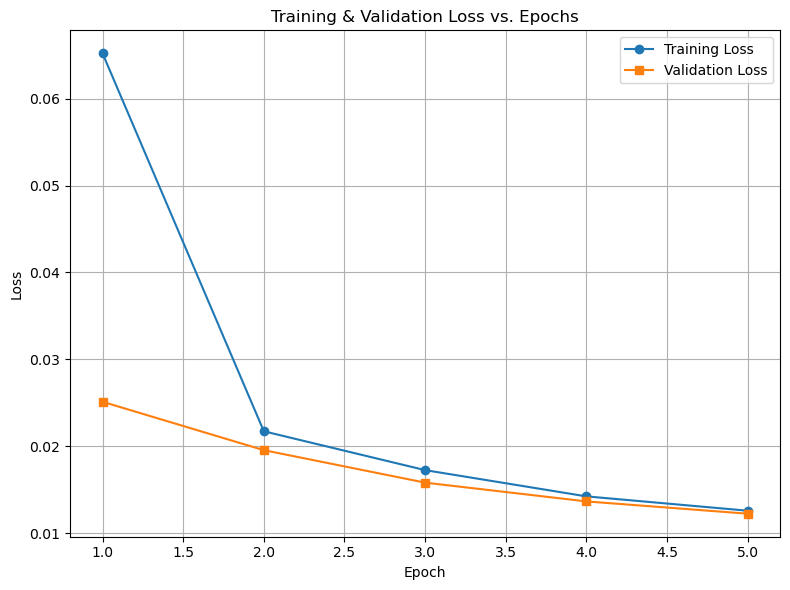

MNIST training set: mean=0.1307, std=0.3081
Angio image: mean=0.5678, std=0.1613


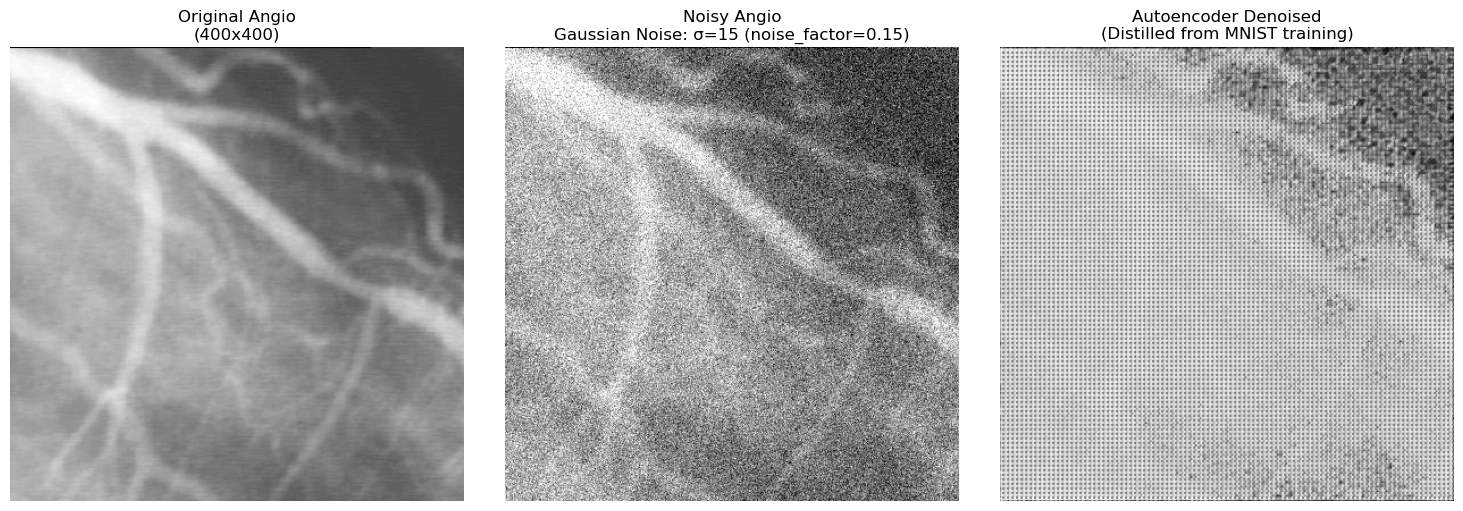

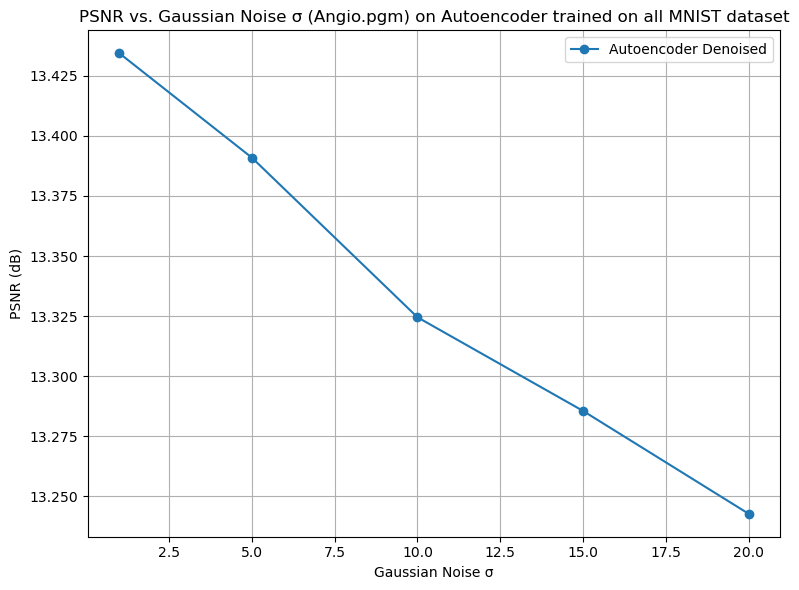

In [112]:
# -----------------------------
# Training the Denoising Autoencoder on ALL MNIST images
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Hyperparameters
batch_size = 128 #128
num_epochs = 5  # For demonstration; adjust as needed #5
learning_rate = 0.001 # .001
# Optimizer: Adam; Loss: MSE

# training sigma
training_noise_sigma = .05

# Use MNIST training set
transform = transforms.ToTensor()
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# ADDED: Create a training/validation split: 150 images for validation, rest for training.
seed = 42
np.random.seed(seed)
indices = np.arange(len(mnist_train))
np.random.shuffle(indices)
val_indices = indices[:150]         # 150 validation images
train_indices = indices[150:]         # Rest for training
train_subset = torch.utils.data.Subset(mnist_train, train_indices)
val_subset = torch.utils.data.Subset(mnist_train, val_indices)
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
# End ADDED

model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Training Autoencoder...")

loss_history = []      # List to record training loss per epoch
val_loss_history = []  # List to record validation loss per epoch
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        # Add Gaussian noise (using a noise factor, e.g., 0.5)
        noisy_images = add_noise(images, noise_factor=training_noise_sigma)
        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    loss_history.append(epoch_loss)
    
    # Compute validation loss
    running_val_loss = 0.0
    with torch.no_grad():
        for val_images, _ in val_loader:
            val_images = val_images.to(device)
            noisy_val = add_noise(val_images, noise_factor=training_noise_sigma)
            outputs_val = model(noisy_val)
            val_loss = criterion(outputs_val, val_images)
            running_val_loss += val_loss.item() * val_images.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_loss_history.append(epoch_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
print("Training completed.")

# ADDED: Plot Training Loss and Validation Loss vs. Epochs on the same figure
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), loss_history, 'o-', label="Training Loss")
plt.plot(range(1, num_epochs+1), val_loss_history, 's-', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss vs. Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# -----------------------------
# Load Angio.pgm image and prepare it
# -----------------------------
# Assume "Angio.pgm" is a 400x400 grayscale image.
angio_path = "Angio.pgm"
if not os.path.exists(angio_path):
    raise FileNotFoundError(f"File {angio_path} not found.")
angio_img = plt.imread(angio_path)
if angio_img.ndim == 3:
    angio_img = angio_img[..., 0]
if angio_img.max() > 1:
    angio_img = angio_img / 255.0
# Convert to torch tensor with shape (1,1,H,W)
angio_tensor = torch.from_numpy(angio_img).unsqueeze(0).unsqueeze(0).float().to(device)

# ADDED: Analyze statistics of MNIST training set vs. Angio image.
# Compute MNIST statistics (using a batch for efficiency)
mnist_data = []
for imgs, _ in DataLoader(mnist_train, batch_size=1000, shuffle=False):
    mnist_data.append(imgs)
mnist_data = torch.cat(mnist_data, dim=0)
mnist_mean = mnist_data.mean().item()
mnist_std = mnist_data.std().item()
print(f"MNIST training set: mean={mnist_mean:.4f}, std={mnist_std:.4f}")

angio_mean = angio_img.mean()
angio_std = angio_img.std()
print(f"Angio image: mean={angio_mean:.4f}, std={angio_std:.4f}")

# -----------------------------
# Denoise Angio image with a fixed Gaussian noise level
# -----------------------------
# Choose a noise sigma (in our domain, noise_factor = sigma/scale)
example_sigma = 15  # for example
noise_factor = example_sigma / 100.0
angio_noisy = add_noise(angio_tensor, noise_factor=noise_factor)
with torch.no_grad():
    angio_denoised = model(angio_noisy)
    
# Move to CPU and convert to numpy for display; ADDED: Clip denoised output to [0,1]
angio_original_np = angio_tensor.squeeze().cpu().numpy()
angio_noisy_np = angio_noisy.squeeze().cpu().numpy()
angio_denoised_np = np.clip(angio_denoised.squeeze().cpu().numpy(), 0, 1)

# -----------------------------
# Create figure: Original, Noisy, Denoised (with parameters on subplots)
# -----------------------------
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(angio_original_np, cmap='gray')
plt.title("Original Angio\n(400x400)")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(angio_noisy_np, cmap='gray')
plt.title(f"Noisy Angio\nGaussian Noise: σ={example_sigma} (noise_factor={noise_factor:.2f})")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(angio_denoised_np, cmap='gray')
plt.title("Autoencoder Denoised\n(Distilled from MNIST training)")
plt.axis('off')

plt.tight_layout()
plt.show()

# -----------------------------
# Create graph: PSNR vs. Gaussian Sigma applied to the Angio image
# -----------------------------
gaussian_sigmas = [1, 5, 10, 15, 20]
psnr_b = []  # PSNR for autoencoder denoising

for sigma in gaussian_sigmas:
    nf = sigma / 100.0
    angio_noisy_sigma = add_noise(angio_tensor, noise_factor=nf)
    with torch.no_grad():
        angio_denoised_sigma = model(angio_noisy_sigma)
    # Convert to numpy and clip to [0,1]
    noisy_np = angio_noisy_sigma.squeeze().cpu().numpy()
    denoised_np = np.clip(angio_denoised_sigma.squeeze().cpu().numpy(), 0, 1)
    
    psnr_val = calculate_psnr(angio_original_np, denoised_np)
    psnr_b.append(psnr_val)

plt.figure(figsize=(8,6))
plt.plot(gaussian_sigmas, psnr_b, 'o-', label="Autoencoder Denoised")
plt.xlabel("Gaussian Noise σ")
plt.ylabel("PSNR (dB)")
plt.title("PSNR vs. Gaussian Noise σ (Angio.pgm) on Autoencoder trained on all MNIST dataset")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Using device: cpu
Training Autoencoder...
Epoch [1/150], Loss: 0.3017, Val Loss: 0.3009
Epoch [2/150], Loss: 0.2988, Val Loss: 0.2980
Epoch [3/150], Loss: 0.2958, Val Loss: 0.2952
Epoch [4/150], Loss: 0.2931, Val Loss: 0.2925
Epoch [5/150], Loss: 0.2903, Val Loss: 0.2899
Epoch [6/150], Loss: 0.2878, Val Loss: 0.2873
Epoch [7/150], Loss: 0.2852, Val Loss: 0.2849
Epoch [8/150], Loss: 0.2826, Val Loss: 0.2820
Epoch [9/150], Loss: 0.2799, Val Loss: 0.2794
Epoch [10/150], Loss: 0.2772, Val Loss: 0.2769
Epoch [11/150], Loss: 0.2746, Val Loss: 0.2741
Epoch [12/150], Loss: 0.2718, Val Loss: 0.2711
Epoch [13/150], Loss: 0.2690, Val Loss: 0.2682
Epoch [14/150], Loss: 0.2663, Val Loss: 0.2652
Epoch [15/150], Loss: 0.2633, Val Loss: 0.2625
Epoch [16/150], Loss: 0.2605, Val Loss: 0.2593
Epoch [17/150], Loss: 0.2573, Val Loss: 0.2565
Epoch [18/150], Loss: 0.2543, Val Loss: 0.2533
Epoch [19/150], Loss: 0.2513, Val Loss: 0.2502
Epoch [20/150], Loss: 0.2480, Val Loss: 0.2466
Epoch [21/150], Loss: 0.245

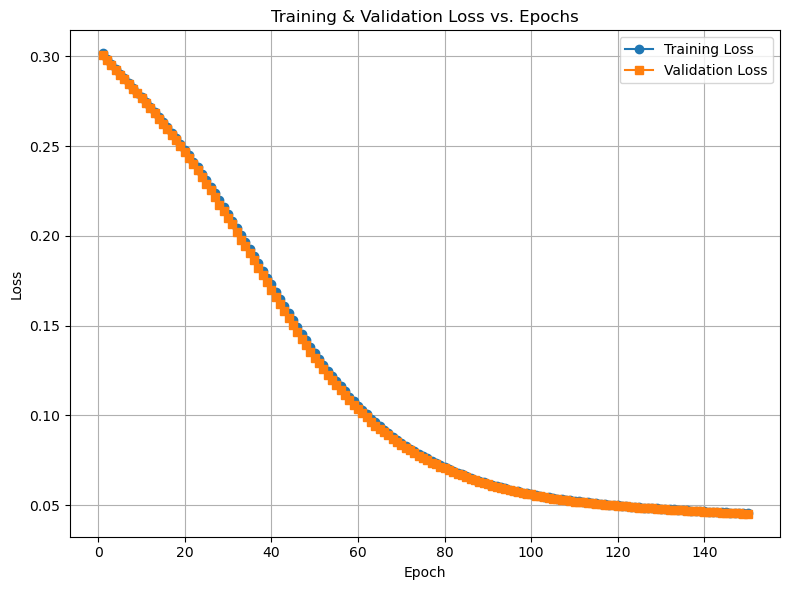

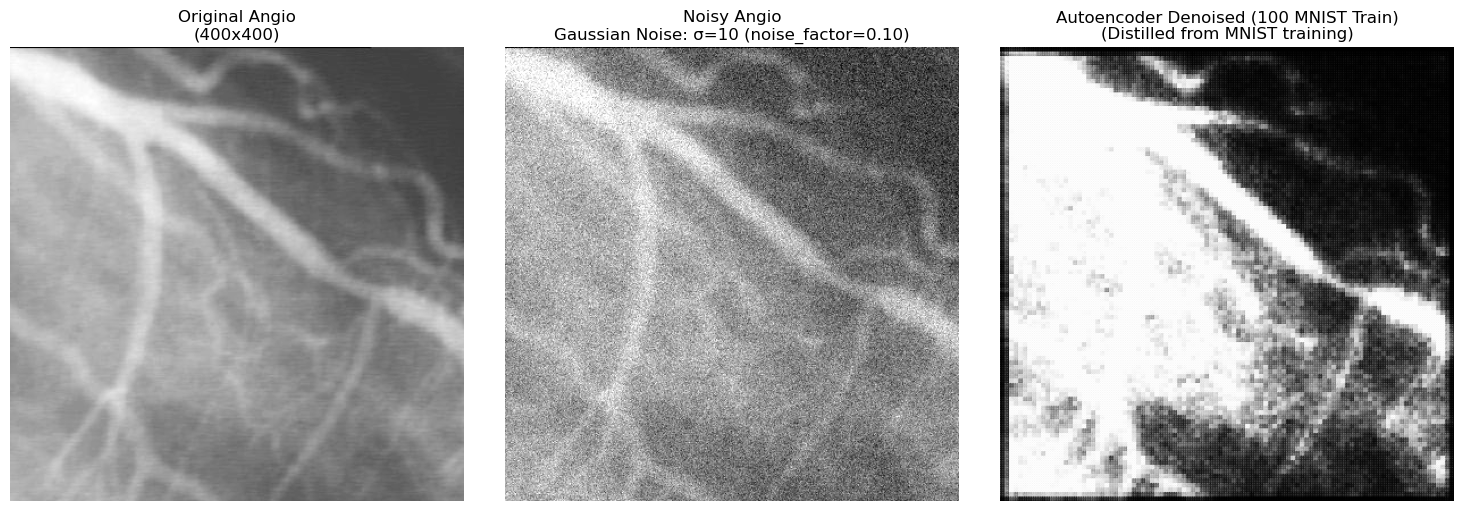

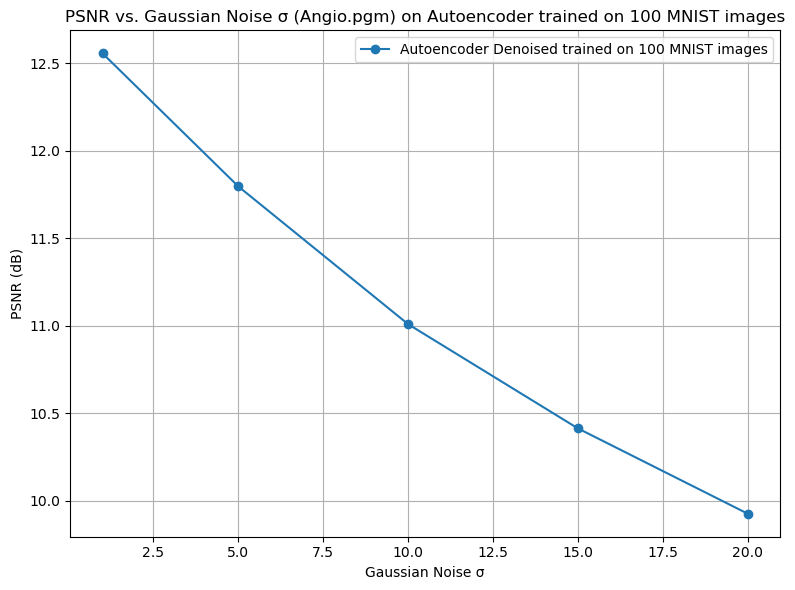

In [54]:
# -----------------------------
# Training the Denoising Autoencoder on MNIST - Trained on 100 MNIST images
# -----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Hyperparameters
batch_size = 128
num_epochs = 150  # For demonstration; adjust as needed
learning_rate = 0.0014
# Optimizer: Adam; Loss: MSE
training_sigma_noise = .2


example_sigma = 10  # for example

# Use MNIST training set, but only select 100 random images for training
transform = transforms.ToTensor()
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
# ADDED: Subsample 100 images from the training set (repeatable)
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
indices_train = np.random.choice(len(mnist_train), 100, replace=False)
train_subset = torch.utils.data.Subset(mnist_train, indices_train)
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
# ADDED: Create validation set of 50 images not in training set
all_indices = np.arange(len(mnist_train))
val_indices_pool = np.setdiff1d(all_indices, indices_train)
np.random.seed(seed)  # ADDED: Re-seed to ensure validation set selection is repeatable
val_indices = np.random.choice(val_indices_pool, 50, replace=False)
val_subset = torch.utils.data.Subset(mnist_train, val_indices)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
# End ADDED

model = DenoisingAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print("Training Autoencoder...")

loss_history = []     # List to record training loss for each epoch
val_loss_history = [] # ADDED: List to record validation loss for each epoch
for epoch in range(num_epochs):
    running_loss = 0.0
    for images, _ in train_loader:
        images = images.to(device)
        # Add Gaussian noise (using a noise factor, e.g., 0.5)
        noisy_images = add_noise(images, noise_factor=training_sigma_noise)
        outputs = model(noisy_images)
        loss = criterion(outputs, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
    epoch_loss = running_loss / len(train_loader.dataset)
    loss_history.append(epoch_loss)
    
    # ADDED: Compute validation loss for this epoch
    running_val_loss = 0.0
    with torch.no_grad():
        for val_images, _ in val_loader:
            val_images = val_images.to(device)
            noisy_val = add_noise(val_images, noise_factor=training_sigma_noise)
            outputs_val = model(noisy_val)
            val_loss = criterion(outputs_val, val_images)
            running_val_loss += val_loss.item() * val_images.size(0)
    epoch_val_loss = running_val_loss / len(val_loader.dataset)
    val_loss_history.append(epoch_val_loss)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {epoch_val_loss:.4f}")
print("Training completed.")

# ADDED: Plot Training Loss and Validation Loss vs. Epochs on the same figure
plt.figure(figsize=(8,6))
plt.plot(range(1, num_epochs+1), loss_history, 'o-', label="Training Loss")
plt.plot(range(1, num_epochs+1), val_loss_history, 's-', label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss vs. Epochs")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# -----------------------------
# Load Angio.pgm image and prepare it
# -----------------------------
# Assume "Angio.pgm" is a 400x400 grayscale image.
angio_path = "Angio.pgm"
if not os.path.exists(angio_path):
    raise FileNotFoundError(f"File {angio_path} not found.")
angio_img = plt.imread(angio_path)
if angio_img.ndim == 3:
    angio_img = angio_img[..., 0]
if angio_img.max() > 1:
    angio_img = angio_img / 255.0
# Convert to torch tensor with shape (1,1,H,W)
angio_tensor = torch.from_numpy(angio_img).unsqueeze(0).unsqueeze(0).float().to(device)

# -----------------------------
# Denoise Angio image with a fixed Gaussian noise level
# -----------------------------
# Choose a noise sigma (in our domain, noise_factor = sigma/scale)
noise_factor = example_sigma / 100.0
angio_noisy = add_noise(angio_tensor, noise_factor=noise_factor)
with torch.no_grad():
    angio_denoised = model(angio_noisy)
    
# Move to CPU and convert to numpy for display
angio_original_np = angio_tensor.squeeze().cpu().numpy()
angio_noisy_np = angio_noisy.squeeze().cpu().numpy()
angio_denoised_np = angio_denoised.squeeze().cpu().numpy()

# -----------------------------
# Create figure: Original, Noisy, Denoised (with parameters on subplots)
# -----------------------------
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(angio_original_np, cmap='gray')
plt.title("Original Angio\n(400x400)")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(angio_noisy_np, cmap='gray')
plt.title(f"Noisy Angio\nGaussian Noise: σ={example_sigma} (noise_factor={noise_factor:.2f})")
plt.axis('off')

plt.subplot(1,3,3)
plt.imshow(angio_denoised_np, cmap='gray')
plt.title("Autoencoder Denoised (100 MNIST Train)\n(Distilled from MNIST training)")
plt.axis('off')

plt.tight_layout()
plt.show()

# -----------------------------
# Create graph: PSNR vs. Gaussian Sigma applied to the Angio image
# -----------------------------
gaussian_sigmas = [1, 5, 10, 15, 20]
psnr_b = []  # PSNR for autoencoder denoising

for sigma in gaussian_sigmas:
    nf = sigma / 100.0
    angio_noisy_sigma = add_noise(angio_tensor, noise_factor=nf)
    with torch.no_grad():
        angio_denoised_sigma = model(angio_noisy_sigma)
    # Convert to numpy
    noisy_np = angio_noisy_sigma.squeeze().cpu().numpy()
    denoised_np = angio_denoised_sigma.squeeze().cpu().numpy()
    
    # Clip the denoised output to [0,1]
    denoised_np = np.clip(denoised_np, 0, 1)

    psnr_val = calculate_psnr(angio_original_np, denoised_np)
    psnr_b.append(psnr_val)

plt.figure(figsize=(8,6))
plt.plot(gaussian_sigmas, psnr_b, 'o-', label="Autoencoder Denoised trained on 100 MNIST images")
plt.xlabel("Gaussian Noise σ")
plt.ylabel("PSNR (dB)")
plt.title("PSNR vs. Gaussian Noise σ (Angio.pgm) on Autoencoder trained on 100 MNIST images")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


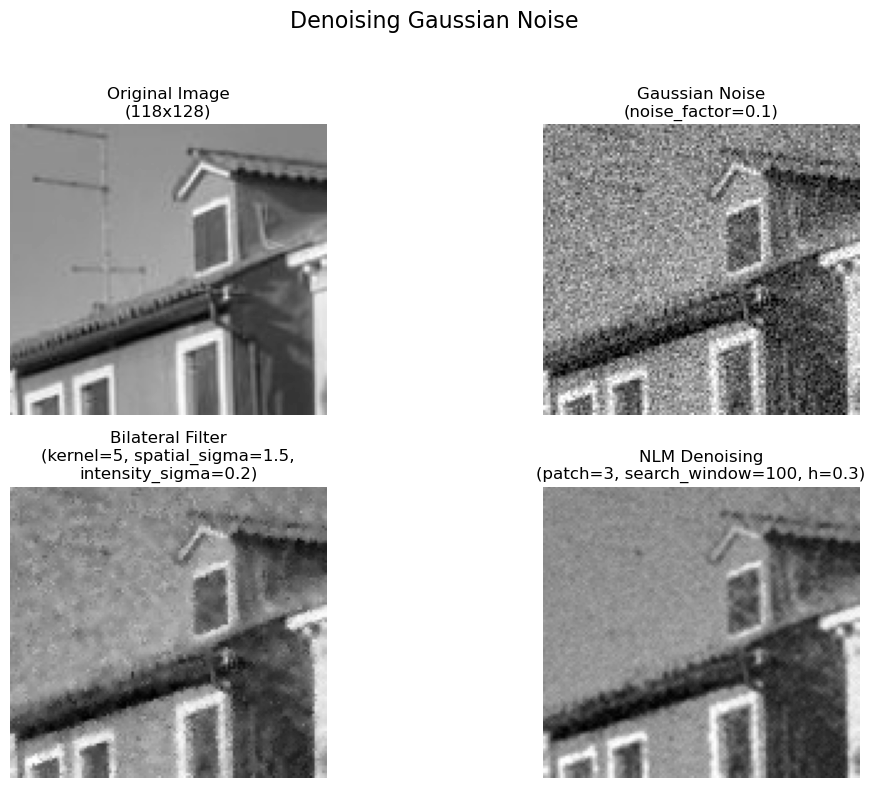

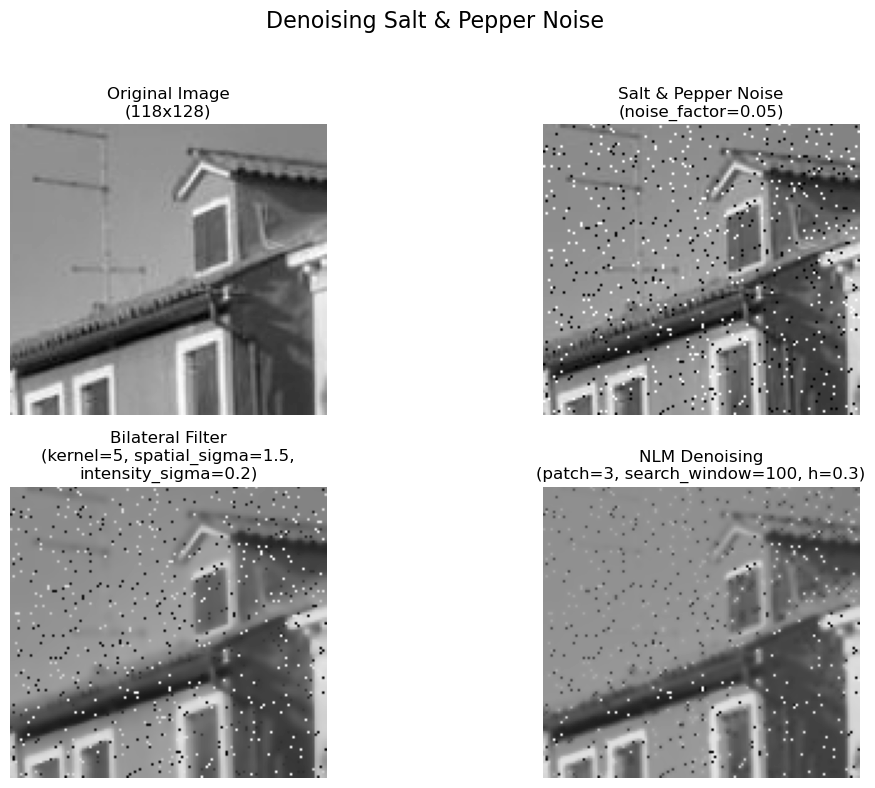

In [12]:
### NO LONGER USED

# =============================
# New code: Noise addition and denoising on the new image stored in variable 'filename'
# =============================

# PARAMETERS: Change these values as needed
gaussian_noise_factor = 0.1       # sigma for Gaussian noise
salt_pepper_noise_factor = 0.05     # fraction of pixels to alter for salt & pepper noise

# Bilateral filtering parameters
bilateral_kernel_size = 5
bilateral_spatial_sigma = 1.5
bilateral_intensity_sigma = 0.2

# Non-local Means (NLM) denoising parameters
nlm_patch_size = 3
nlm_search_window = 100
nlm_h = 0.3

filename = "building_small.png"

# Load the new image using PIL and convert to grayscale
img_pil = Image.open(filename).convert('L')
# Convert image to numpy array (values in [0,1]) and cast to float32
img_np = np.array(img_pil).astype(np.float32) / 255.0
# Get image dimensions dynamically
img_height, img_width = img_np.shape

# Convert numpy image to torch tensor for noise addition (shape: [1, 1, H, W])
img_tensor = torch.from_numpy(img_np).unsqueeze(0).unsqueeze(0)

# Apply Gaussian noise
img_tensor_gaussian = add_noise(img_tensor, noise_factor=gaussian_noise_factor)
gaussian_np = img_tensor_gaussian.squeeze().cpu().numpy()

# Apply Salt & Pepper noise
img_tensor_sp = add_salt_pepper_noise(img_tensor, noise_factor=salt_pepper_noise_factor)
salt_pepper_np = img_tensor_sp.squeeze().cpu().numpy()

# Denoise the Gaussian noisy image using Bilateral filtering and NLM
bilateral_gaussian = bilateral_filter(gaussian_np, kernel_size=bilateral_kernel_size, 
                                      spatial_sigma=bilateral_spatial_sigma, intensity_sigma=bilateral_intensity_sigma)
nlm_gaussian = non_local_means_denoise(gaussian_np, patch_size=nlm_patch_size, 
                                       search_window=nlm_search_window, h=nlm_h)

# Denoise the Salt & Pepper noisy image using Bilateral filtering and NLM
bilateral_sp = bilateral_filter(salt_pepper_np, kernel_size=bilateral_kernel_size, 
                                spatial_sigma=bilateral_spatial_sigma, intensity_sigma=bilateral_intensity_sigma)
nlm_sp = non_local_means_denoise(salt_pepper_np, patch_size=nlm_patch_size, 
                                 search_window=nlm_search_window, h=nlm_h)

# Create figure for Gaussian noise denoising
plt.figure(figsize=(12, 8))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(img_np, cmap='gray')
plt.title(f"Original Image\n({img_height}x{img_width})")
plt.axis("off")

# Gaussian noise image
plt.subplot(2, 2, 2)
plt.imshow(gaussian_np, cmap='gray')
plt.title(f"Gaussian Noise\n(noise_factor={gaussian_noise_factor})")
plt.axis("off")

# Bilateral denoised (Gaussian)
plt.subplot(2, 2, 3)
plt.imshow(bilateral_gaussian, cmap='gray')
plt.title(f"Bilateral Filter\n(kernel={bilateral_kernel_size}, spatial_sigma={bilateral_spatial_sigma},\nintensity_sigma={bilateral_intensity_sigma})")
plt.axis("off")

# NLM denoised (Gaussian)
plt.subplot(2, 2, 4)
plt.imshow(nlm_gaussian, cmap='gray')
plt.title(f"NLM Denoising\n(patch={nlm_patch_size}, search_window={nlm_search_window}, h={nlm_h})")
plt.axis("off")

plt.suptitle("Denoising Gaussian Noise", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Create figure for Salt & Pepper noise denoising
plt.figure(figsize=(12, 8))

# Original image
plt.subplot(2, 2, 1)
plt.imshow(img_np, cmap='gray')
plt.title(f"Original Image\n({img_height}x{img_width})")
plt.axis("off")

# Salt & Pepper noise image
plt.subplot(2, 2, 2)
plt.imshow(salt_pepper_np, cmap='gray')
plt.title(f"Salt & Pepper Noise\n(noise_factor={salt_pepper_noise_factor})")
plt.axis("off")

# Bilateral denoised (Salt & Pepper)
plt.subplot(2, 2, 3)
plt.imshow(bilateral_sp, cmap='gray')
plt.title(f"Bilateral Filter\n(kernel={bilateral_kernel_size}, spatial_sigma={bilateral_spatial_sigma},\nintensity_sigma={bilateral_intensity_sigma})")
plt.axis("off")

# NLM denoised (Salt & Pepper)
plt.subplot(2, 2, 4)
plt.imshow(nlm_sp, cmap='gray')
plt.title(f"NLM Denoising\n(patch={nlm_patch_size}, search_window={nlm_search_window}, h={nlm_h})")
plt.axis("off")

plt.suptitle("Denoising Salt & Pepper Noise", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()